<a href="https://colab.research.google.com/github/DannyinDelft/INR/blob/main/February17th_1456.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running on device: cpu
Loading file: /content/drive/My Drive/Thesis_imagery/Ecostress/1000mpatches/Italy/70m/Raster70_Site_10_Italy.tif
Loading file: /content/drive/My Drive/Thesis_imagery/Ecostress/1000mpatches/Italy/120m/Raster_Site_10_Italy.tif
Loaded image shape: torch.Size([1, 1, 1000, 1000])
Loading file: /content/drive/My Drive/Thesis_imagery/Ecostress/1000mpatches/Italy/70m/Raster70_Site_11_Italy.tif
Loading file: /content/drive/My Drive/Thesis_imagery/Ecostress/1000mpatches/Italy/120m/Raster_Site_10_Italy.tif
Loaded image shape: torch.Size([1, 1, 1000, 1000])
Loading file: /content/drive/My Drive/Thesis_imagery/Ecostress/1000mpatches/Italy/70m/Raster70_Site_12_Italy.tif
Loading file: /content/drive/My Drive/Thesis_imagery/Ecostress/1000mpatches/Italy/120m/Raster_Site_10_Italy.tif
Loaded image shape: torch.Size([1, 1, 1000, 1000])
Loading file: /conte

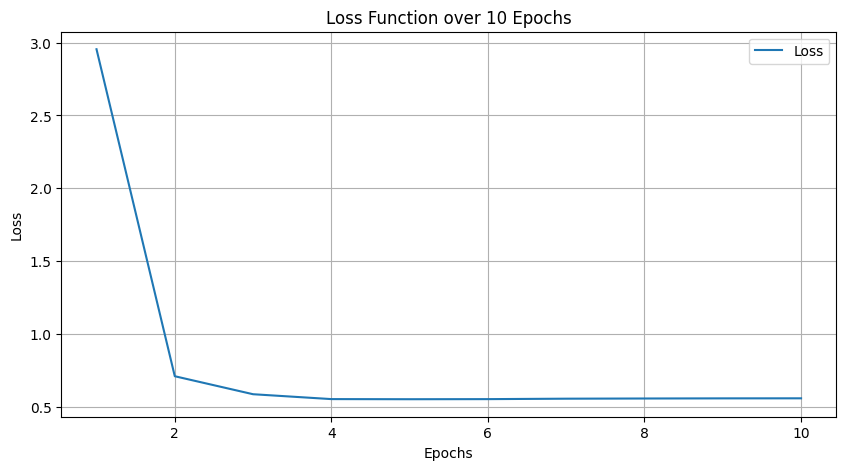

Loading file: /content/drive/My Drive/Thesis_imagery/Ecostress/1000mpatches/Den_Haag/2_14_2023_E_1000.tif
Processed image saved: /content/drive/My Drive/Thesis_imagery/Rendered_images/processed_image_2_14_2023.tif
Loaded image shape: torch.Size([1, 1, 1000, 1000])
Loading file: /content/drive/My Drive/Thesis_imagery/Ecostress/1000mpatches/Den_Haag/4_17_2020_E_1000.tif
Processed image saved: /content/drive/My Drive/Thesis_imagery/Rendered_images/processed_image_4_17_2020.tif
Loaded image shape: torch.Size([1, 1, 1000, 1000])
Loading file: /content/drive/My Drive/Thesis_imagery/Ecostress/1000mpatches/Den_Haag/6_13_2023_E_1000.tif
Processed image saved: /content/drive/My Drive/Thesis_imagery/Rendered_images/processed_image_6_13_2023.tif
Loaded image shape: torch.Size([1, 1, 1000, 1000])
Loading file: /content/drive/My Drive/Thesis_imagery/Ecostress/1000mpatches/Den_Haag/8_13_2022_E_1000.tif
Processed image saved: /content/drive/My Drive/Thesis_imagery/Rendered_images/processed_image_8_13_

In [10]:
# -*- coding: utf-8 -*-
"""
Script with controlled dimensions, normalization, and fixed 30x30 resolution.
"""
!pip install rasterio
!pip install plyfile
!pip install configargparse

import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import rasterio
from google.colab import drive
import matplotlib.pyplot as plt

# Ensure Matplotlib inline for Google Colab
%matplotlib inline

# Mount Google Drive
drive.mount('/content/drive')

# Set device configuration
device = torch.device('cpu')
print(f"Running on device: {device}")

# Define a SIREN Layer with adjustable omega for sharper outputs
class SirenLayer(nn.Module):
    def __init__(self, in_channels, out_channels, omega=50.0, is_first=False):
        super(SirenLayer, self).__init__()
        self.in_channels = in_channels
        self.is_first = is_first
        self.omega = omega
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.conv.weight.uniform_(-1 / self.in_channels, 1 / self.in_channels)
            else:
                self.conv.weight.uniform_(-np.sqrt(6 / self.in_channels) / self.omega, np.sqrt(6 / self.in_channels) / self.omega)

    def forward(self, x):
        return torch.sin(self.omega * self.conv(x))

# Define a memory-efficient SIREN-based model with higher frequency for sharper images
class CustomSirenModel(nn.Module):
    def __init__(self, in_channels=1, interm_channels=32, out_channels=1):
        super(CustomSirenModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, interm_channels, kernel_size=1, stride=1)
        self.siren1 = SirenLayer(interm_channels, interm_channels, omega=50.0, is_first=True)
        self.siren2 = SirenLayer(interm_channels, interm_channels, omega=50.0)
        self.final_conv = nn.Conv2d(interm_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.siren1(x)
        x = self.siren2(x)
        x = self.final_conv(x)
        return x

# Training function
def train(args, model, opt, scheduler):
    model.train()
    loss_values = []

    for epoch in range(args.num_epochs):
        total_loss = 0

        for train_in, profile, _ in image_loader('/content/drive/My Drive/Thesis_imagery/Ecostress/1000mpatches/Italy/70m', target_size=(1000, 1000)):
            train_tgt, _, _ = next(image_loader('/content/drive/My Drive/Thesis_imagery/Ecostress/1000mpatches/Italy/120m', target_size=(1000, 1000)))

            opt.zero_grad()
            outputs = model(train_in)
            loss = nn.MSELoss()(outputs, train_tgt)
            loss.backward()
            opt.step()
            total_loss += loss.item()

            del train_in, train_tgt, outputs
            torch.cuda.empty_cache()

        scheduler.step()
        avg_loss = total_loss
        loss_values.append(avg_loss)
        print(f"Epoch [{epoch+1}/{args.num_epochs}], Loss: {avg_loss:.4f}")

    return loss_values

# Main function for data loading, training, and testing
def main(args):
    model = CustomSirenModel(in_channels=1, interm_channels=32, out_channels=1).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=args.lr)
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1000, gamma=0.5)
    loss_values = train(args, model, opt, scheduler)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, args.num_epochs + 1), loss_values, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Function over 10 Epochs')
    plt.legend()
    plt.grid()
    plt.show()
    #input("Press Enter to continue...")

    # Testing phase - Save outputs
    output_dir = '/content/drive/My Drive/Thesis_imagery/Rendered_images'
    os.makedirs(output_dir, exist_ok=True)

    with torch.no_grad():
        for img_index, (img_batch, profile, date_str) in enumerate(image_loader('/content/drive/My Drive/Thesis_imagery/Ecostress/1000mpatches/Den_Haag', target_size=(1000, 1000))):
            outputs = model(img_batch)
            outputs = (outputs - outputs.min()) / (outputs.max() - outputs.min()) * 255
            outputs = outputs.byte()
            image_filename = f'{output_dir}/processed_image_{date_str}.tif'
            profile.update({'dtype': 'uint8','count': 1,'height': 1000,'width': 1000})
            with rasterio.open(image_filename, 'w', **profile) as dst:
                dst.write(outputs.cpu().numpy()[0, 0, :, :], 1)
            print(f"Processed image saved: {image_filename}")
            torch.cuda.empty_cache()

if __name__ == '__main__':
    class Args:
        device = device
        batch_size = 1
        lr = 1e-4
        num_epochs = 50
    args = Args()
    main(args)
